In [1]:
import pandas as pd
import numpy as np
import operator
from scipy import stats
import matplotlib.pylab as pl
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
pl.style.use('ggplot')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Directly read the Local Law 84 dataset to get energy use information in 2014

In [2]:
df = pd.read_csv('https://data.cityofnewyork.us/api/views/jzst-u7j8/rows.csv?accessType=DOWNLOAD')
df.head()

,Record Number,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Street Number,Street Name,Borough,Postcode,BBL on the Covered Buildings List,...,DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA
0,2830985.0,4160830037,NaN,NaN,4303321,71,BEACH 70 STREET,QUEENS,11692.0,Yes,...,155000.0,Multifamily Housing,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2858535.0,4002520018,NaN,NaN,4003447,32-36,47 AVENUE,QUEENS,11101.0,Yes,...,184400.0,Office,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2804445.0,3009747504,NaN,NaN,3392416,302,2 AVENUE,BROOKLYN,11215.0,Yes,...,58506.0,Multifamily Housing,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2805372.0,4032937501,NaN,NaN,4308252,110,73 ROAD,QUEENS,11375.0,Yes,...,100800.0,Multifamily Housing,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2664866.0,4000540006,NaN,NaN,4000460,11-36,45 ROAD,QUEENS,11101.0,Yes,...,56000.0,Worship Facility,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.columns

Index([u'Record Number', u'BBL', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identification Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Postcode',
       u'BBL on the Covered Buildings List',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings',
       u'Latitude', u'Longitude', u'Community Board', u'Co

## Find the top 5 major building types

In [4]:
mydict = dict(zip(df.groupby('Primary Property Type - Self Selected')['Record Number'].count().index, 
                  df.groupby('Primary Property Type - Self Selected')["Record Number"].count().values))
sorted(mydict.items(), key = operator.itemgetter(1), reverse=True)[:6]

[('Multifamily Housing', 8552),
 ('Office', 1235),
 ('Other', 215),
 ('Hotel', 187),
 ('Not Available', 182),
 ('Non-Refrigerated Warehouse', 169)]

## Focus on Multifamily Housing since it accouts for nearly 80% of all buildings

In [5]:
df = df[df['Primary Property Type - Self Selected']== 'Multifamily Housing']
df.head()

,Record Number,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Street Number,Street Name,Borough,Postcode,BBL on the Covered Buildings List,...,DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA
0,2830985.0,4160830037,NaN,NaN,4303321,71,BEACH 70 STREET,QUEENS,11692.0,Yes,...,155000.0,Multifamily Housing,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2804445.0,3009747504,NaN,NaN,3392416,302,2 AVENUE,BROOKLYN,11215.0,Yes,...,58506.0,Multifamily Housing,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2805372.0,4032937501,NaN,NaN,4308252,110,73 ROAD,QUEENS,11375.0,Yes,...,100800.0,Multifamily Housing,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2669439.0,4096490053,NaN,NaN,4206516,85-02,MANTON STREET,QUEENS,11435.0,Yes,...,92000.0,Multifamily Housing,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2726160.0,4030780103,NaN,NaN,4072035,93-40,QUEENS BOULEVARD,QUEENS,11374.0,Yes,...,52080.0,Multifamily Housing,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Remove the outliers that are zeros or larger than 1000

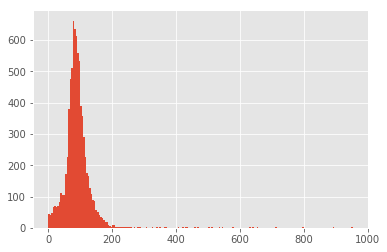

In [6]:
df = df.dropna(subset=["Site EUI(kBtu/ft2)"])
df = df[df['Site EUI(kBtu/ft2)']>0]
plt.hist(df["Site EUI(kBtu/ft2)"][df["Site EUI(kBtu/ft2)"]<1000], bins=200)
plt.show()

## Remove the outliers whose log value is out range of 2std level

In [7]:
df["eui"] = df["Site EUI(kBtu/ft2)"]
df["log_eui"] = np.log10(df.eui)
df = df[(df.log_eui<np.mean(df.log_eui)+1*np.std(df.log_eui))&(df.log_eui>np.mean(df.log_eui)-2*np.std(df.log_eui))]
df.shape

(7409, 35)

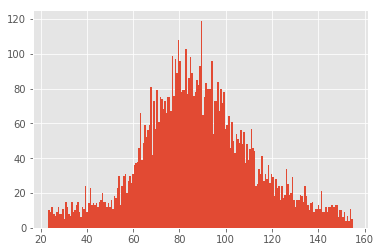

In [8]:
plt.hist(df["Site EUI(kBtu/ft2)"], bins=200)
plt.show()

In [9]:
df.eui.describe()

count    7409.000000
mean       87.886004
std        25.055868
min        23.400000
25%        72.100000
50%        86.800000
75%       102.900000
max       154.900000
Name: eui, dtype: float64

## Get the data that only contains the information about EUI and Score

In [13]:
df = df[['Site EUI(kBtu/ft2)','ENERGY STAR Score']]
df.head()

,Site EUI(kBtu/ft2),ENERGY STAR Score
0,115.1,20
2,102.3,9
3,44.6,Not Available
5,89.5,Not Available
6,97.2,57


In [14]:
df.iloc[2,1]

'Not Available'

## Remove the columns whose number is not available

In [17]:
df = df[df['ENERGY STAR Score']!='Not Available']
df.head()

,Site EUI(kBtu/ft2),ENERGY STAR Score
0,115.1,20
2,102.3,9
6,97.2,57
7,105.2,50
8,74.6,78


In [24]:
df['ENERGY STAR Score'] = df['ENERGY STAR Score'].astype(int)

In [33]:
df.columns = ['EUI','Score']

## Use the OLS funciton to get fit line and its summary

In [35]:
lm = smf.ols(formula='EUI~Score',data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    EUI   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     7257.
Date:                Tue, 14 Nov 2017   Prob (F-statistic):               0.00
Time:                        16:21:18   Log-Likelihood:                -26047.
No. Observations:                6121   AIC:                         5.210e+04
Df Residuals:                    6119   BIC:                         5.211e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    123.5216      0.469    263.418      0.000       122.602   124.441
Score         -0.6538      0.008    -85.189      0.000        -0.669    -0.639
==============================================================================
Omnibus:                      359.849   Durbin-Watson:                   1.666
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              576.092
Skew:                          -0.482   Prob(JB):                    8.00e-126
Kurtosis:                       4.153   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Plot the EUI, Energy Score and the linear regression fit line

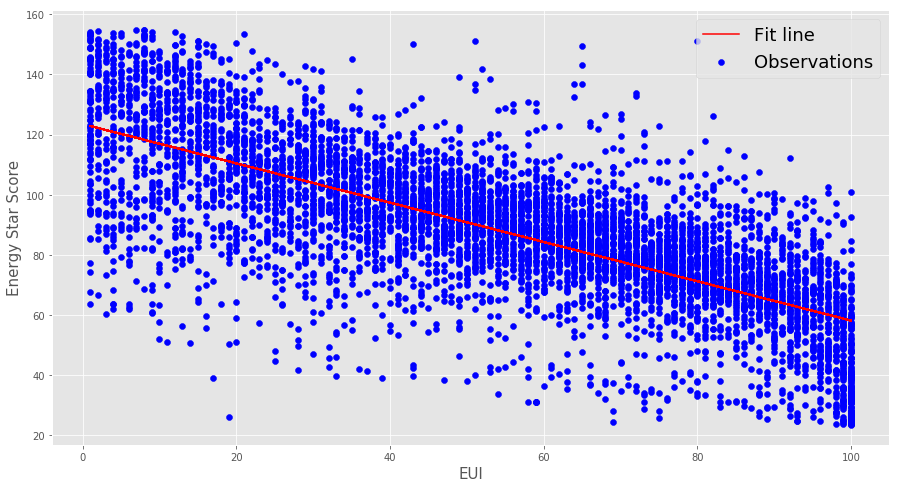

In [45]:
fig = pl.figure(figsize=(15,8))
pl.scatter(df['Score'], df['EUI'],color = "blue", label = "Observations")
pl.plot(df['Score'],lm.predict(),color = "red", label = 'Fit line')
pl.xlabel('EUI', fontsize = 15)
pl.ylabel('Energy Star Score', fontsize = 15)
pl.legend(loc='best', fontsize = 18)
pl.show()


## Figure 1:  The plot of EUI, Energy star score of the mutifamily housing reported in LL84 in 2014 and the linear regression fit line. The R-square is 0.543 which shows that there is a not very strong linear correlation between EUI and Energy score. However when we directly look at the plot, we can easily find there is a general negative correlation between the two variables